In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import copy

import torch
import torch.nn.functional as F
from torch import nn
from torch.utils.data import DataLoader, TensorDataset

from tqdm.auto import tqdm
import random
from collections import Counter
import re
import json

##**Dataset**

### **Tinyshakespeare**

In [ ]:
!wget "https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt"

--2025-05-15 08:06:47--  https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1115394 (1.1M) [text/plain]
Saving to: ‘input.txt’

input.txt           100%[===================>]   1.06M  --.-KB/s    in 0.04s   

2025-05-15 08:06:47 (26.8 MB/s) - ‘input.txt’ saved [1115394/1115394]



In [ ]:
with open('/content/input.txt', mode='r', encoding='utf-8') as f:
    text = f.read()

print('Length of data: ', len(text))
print(text[:100])

Length of data:  1115394
First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You


### **Wikipedia**

in the article: [WikiDes: A Wikipedia-Based Dataset for Generating Short Descriptions from Paragraphs](https://arxiv.org/abs/2209.13101) by Hoang Thang Ta et al. there is a good wikipedia dataset: [Link](https://github.com/declare-lab/WikiDes?tab=readme-ov-file)

<br>

> I saved it to my drive and copy the file here


In [ ]:
!cp /content/drive/MyDrive/LLM/collected_data.zip /content/
!unzip /content/collected_data.zip

Archive:  /content/collected_data.zip
  inflating: collected_data.json     


In [ ]:
with open('/content/collected_data.json', "r") as f:
    raw = f.read()

listed_text = [item + '}' for item in raw.split('},')]
print(len(listed_text))

91567


In [ ]:
def remove_non_latin_words(text):
    # Keep only words made of basic English letters
    tokens = re.findall(r'[a-zA-Z]+[.,!?:;]*', text)
    return ' '.join(tokens)

In [ ]:
data = []
for item in listed_text:
    try:
        item = json.loads(item)['first_paragraph']
        data.append(remove_non_latin_words(item))
    except:
        continue


print(len(data))

91484


In [ ]:
# Data is too big, so I used 10000 of them
text = '\n'.join(data[:10000])

In [ ]:
len(text)

4745946

## **WordPiece Tokenizer**

In [ ]:
class WordPiece():
    def __init__(self, text):
        self.text = text  # Store input text

    def train(self, num_iteration=1000, freq_limit=5, likeli_iteration=30, load_char_lvl=False, save_path=False):
        """
        Train the WordPiece tokenizer using an entropy-based merge strategy.

        Parameters:
        - num_iteration: number of merge iterations.
        - freq_limit: minimum frequency for a character pair to be considered.
        - likeli_iteration: number of top pairs to evaluate for entropy reduction.
        - load_char_lvl: path to a saved character-level word list to resume from.
        - save_path: path to save the intermediate results.
        """

        # Load character-level representation if provided
        if load_char_lvl:
            character_lvl_words = np.load(load_char_lvl, allow_pickle=True).tolist()
        else:
            words, _ = self._clean_text(self.text)

            # Flatten the list of sentences into a list of words
            flatten_words = [word for sentence in words for word in sentence]

            # Convert each word into a list of characters
            character_lvl_words = [[ch for ch in word] for word in flatten_words]

        # Progress bar for the outer merge loop
        pbar = tqdm(range(num_iteration), desc="Outer loop progress")

        for _ in pbar:
            # Count all character bigram frequencies
            pairs = {}
            for word in character_lvl_words:
                for pair in zip(word[:-1], word[1:]):
                    pairs[pair] = pairs.get(pair, 0) + 1

            best_prob = float('-inf')
            best_pair = None
            best_merged = None

            # Get the top frequent pairs for evaluation
            common_pairs = Counter(pairs).most_common(likeli_iteration)

            inner_pbar = tqdm(common_pairs, desc="Evaluating pairs", leave=False)

            for pair, freq in inner_pbar:
                if freq > freq_limit:
                    pair_str = ' '.join(pair)

                    # Merge candidate pair in all words
                    merged = self._merge(character_lvl_words, pair_str)

                    # Compute entropy change
                    prob_dif = self._log_likelihood_entropy(character_lvl_words, merged)

                    # Update best merge based on entropy gain
                    if prob_dif > best_prob:
                        best_prob = prob_dif
                        best_pair = pair
                        best_merged = merged

                inner_pbar.set_postfix({"Best pair": best_pair, "Δ log-likelihood": f"{best_prob:.4f}"})

            if best_pair is None:
                break  # Stop if no improvement

            character_lvl_words = best_merged

            if save_path:
                np.save('/content/WordPiececharacter_lvl_words.npy', np.array(character_lvl_words, dtype=object))
                # Optionally copy the saved file to another location
                # !cp '/content/WordPiececharacter_lvl_words.npy' save_path

            pbar.set_description(f"Best pair: {best_pair}, Δ log-likelihood: {best_prob:.4f}")

        # Apply WordPiece prefixes
        tokens = self._add_wordpiece_prefixes(character_lvl_words)
        flat_tokens = [tok for word in tokens for tok in word]
        self.tokens = sorted(set(flat_tokens))

        # Add special tokens for BERT-style models
        for special in ['.', '[CLS]', '[SEP]', '[UNK]', '[MASK]', '[PAD]']:
            self.tokens.insert(0, special)

        # Create lookup dictionaries for token-to-index and index-to-token
        self.stoi = {ch: i for i, ch in enumerate(self.tokens)}
        self.itos = {i: ch for i, ch in enumerate(self.tokens)}

    def preprocess_text(self):
        """
        Clean and structure the text into a suitable format for training or evaluation.
        Splits long sentences, handles poetic structure, and tokenizes the result.
        """
        _, cleaned_text = self._clean_text(self.text)

        new_text = []
        for item in cleaned_text:
            item = item.replace('\n', ' ')
            if len(item.split()) > 50:
                new_text.append(self._split_poetic_text(item)[0])
            else:
                new_text.append(item)

        max_len = 90
        i = 0
        pbar = tqdm(total=len(new_text), desc="Merging Sentences")
        while i < len(new_text) - 1:
            if len(new_text[i].split()) > max_len:
                new_text[i] = ' '.join(new_text[i].split()[:max_len])
                i += 1
                pbar.update(1)
                continue

            merged = new_text[i] + ' . ' + new_text[i + 1]
            if len(merged.split()) > max_len:
                i += 1
                pbar.update(1)
                continue

            new_text[i] = merged
            del new_text[i + 1]
            # No need to increment i here, because we might be able to merge again

            pbar.update(1)

        pbar.close()

        new_text = new_text[:-1]

        self.tokenized_text = []
        for idx, item in tqdm(enumerate(new_text), total=len(new_text), desc="Tokenizing"):
            tokens = [self._tokenize_string(word, self.tokens) for word in item.split()]
            self.tokenized_text.append([tok for sublist in tokens for tok in sublist])

    def _merge(self, words, pair_str):
        """
        Merge a specified character pair throughout all tokenized words.
        """
        a, b = pair_str.split()
        new_words = []

        for word in words:
            i = 0
            new_word = []
            while i < len(word):
                if i < len(word) - 1 and word[i] == a and word[i + 1] == b:
                    new_word.append(a + b)
                    i += 2
                else:
                    new_word.append(word[i])
                    i += 1
            new_words.append(new_word)

        return new_words

    def _add_wordpiece_prefixes(self, token_list):
        """
        Add WordPiece continuation prefixes (##) to all subword tokens except the first in each word.
        """
        result = []
        for word in token_list:
            if not word:
                continue
            result.append([word[0]] + ['##' + t for t in word[1:]])
        return result

    def _log_likelihood_entropy(self, before, after):
        """
        Compute change in token entropy (Δ entropy = before - after).
        """
        def entropy(counts):
            probs = counts / counts.sum()
            return -np.sum(probs * np.log(probs + 1e-12))  # small epsilon for stability

        flat_before = [token for word in before for token in word]
        flat_after = [token for word in after for token in word]

        before_counts = np.array(list(Counter(flat_before).values()), dtype=np.float64)
        after_counts = np.array(list(Counter(flat_after).values()), dtype=np.float64)

        return entropy(before_counts) - entropy(after_counts)

    def _clean_text(self, text):
        """
        Clean the input text:
        - Remove metadata (e.g. speaker tags)
        - Split into sentences
        - Keep only sentences with more than 3 words
        """
        pattern = r'^.*?:.*$\n?'
        cleaned = re.sub(pattern, '', text, flags=re.MULTILINE)

        pattern = r'[.?!]\s*'
        sentences = re.split(pattern, cleaned)

        words = [s.split() for s in sentences if len(s.split()) > 3]
        sentences = [s for s in sentences if len(s.split()) > 3]

        return words, sentences

    def _tokenize_string(self, word, tokens_list, unk_token='[UNK]'):
        """
        Tokenize a single word using the WordPiece vocabulary.
        Uses longest-match-first strategy.
        """
        tokenized = []
        start = 0

        while start < len(word):
            end = len(word)
            matched = None

            while start < end:
                substr = word[start:end]
                if start > 0:
                    substr = "##" + substr
                if substr in tokens_list:
                    matched = substr
                    break
                end -= 1

            if matched is None:
                tokenized.append(unk_token)
                break

            tokenized.append(matched)
            start = end if matched.startswith("##") else len(matched)

        return tokenized

    def decode_word_piece(self, string, tokens, unk_token='[UNK]'):
        """
        Encode a word to token IDs using WordPiece vocabulary.
        """
        tokenized = self._tokenize_string(string, tokens)
        return [self.stoi[item] if item in self.stoi else self.stoi[unk_token] for item in tokenized]

    def encode_word_piece(self, ids):
        """
        Convert a list of token IDs back to a string (removing ## prefixes).
        """
        tokens = [self.itos[item] for item in ids]
        return ''.join([tok if not tok.startswith('##') else tok[2:] for tok in tokens])

    def _split_poetic_text(self, text, max_words=40, min_words=10):
        """
        Split long poetic text by commas and semicolons into shorter segments.
        """
        clauses = re.split(r'(?<=[,;])\s+', text)

        segments = []
        current = []

        for clause in clauses:
            current.append(clause.strip())
            word_count = sum(len(part.split()) for part in current)

            if word_count >= max_words or (
                word_count >= min_words and clause.strip().endswith((',', ';'))
            ):
                segments.append(' '.join(current).strip())
                current = []

        if current:
            segments.append(' '.join(current).strip())

        return segments

In [ ]:
tokenizer = WordPiece(text)

In [ ]:
tokenizer.train(
    num_iteration=1000-999,
    likeli_iteration=30,
    load_char_lvl='/content/drive/MyDrive/LLM/WikiWordPiececharacter_lvl_words.npy'
)

Outer loop progress:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating pairs:   0%|          | 0/30 [00:00<?, ?it/s]

In [ ]:
print('Number of tokens: ', len(tokenizer.tokens))
print('First 7 tokens: ', tokenizer.tokens[:7])

Number of tokens:  2087
First 7 tokens:  ['[PAD]', '[MASK]', '[UNK]', '[SEP]', '[CLS]', '.', '##,']


In [ ]:
# Let's test the decoder-encoder
ids = tokenizer.decode_word_piece('hello!', tokenizer.tokens)
print(ids, '-->', [tokenizer.itos[id] for id in ids])

tokenizer.encode_word_piece(ids)

[1554, 344, 574, 2] --> ['h', '##el', '##lo', '[UNK]']


'hello[UNK]'

In [ ]:
tokenizer.preprocess_text()

Merging Sentences:   0%|          | 0/26174 [00:00<?, ?it/s]

Tokenizing:   0%|          | 0/6992 [00:00<?, ?it/s]

In [ ]:
tokenizer.tokenized_text[0][:10]

['X', '##y', '##l', '##e', '##bor', '##us', 'i', '##n', '##tru', '##su']

## **Create dataset**

|Term | Role|
|-----|-----|
|attention_mask | Tells the model which tokens are real (1) and which are padding (0).|
|target_ids | Tells the loss function which tokens to compute loss on (-100 ignored).|

<br>

- Attention mask helps the model focus.
- -100 mask helps loss computation focus.

In [ ]:
VOCAB_SIZE = len(tokenizer.stoi)
MAX_LEN = len(max(tokenizer.tokenized_text, key=len))
BATCH_SIZE = 64
LR = 1e-4
EPOCHS = 1000
EVAL_INTERVAL = 2
EVAL_ITER = 5
N_EMBD = 256
N_HEAD = 8
NUM_BLOCK = 12
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
len(max(tokenizer.tokenized_text, key=len))

323

In [ ]:
from torch.utils.data import TensorDataset, random_split

class BertDataset():
    def __init__(self, tokenized_text, stoi, MASK_TOKEN = '[MASK]', PAD_TOKEN = '[PAD]'):

        self.tokenized_text = tokenized_text
        self.stoi = stoi
        self.MASK_ID = self.stoi[MASK_TOKEN]
        self.PAD_ID = self.stoi[PAD_TOKEN]
        self.input_ids = []
        self.attention_masks = []
        self.labels = []

    def preprocess(self):

        for token_list in tqdm(self.tokenized_text):  # tokenized_data is a list of token lists
            ids = [self.stoi[token] if token in self.stoi else self.stoi['[UNK]'] for token in token_list]
            padded = self._pad_sequence(ids, MAX_LEN)
            masked_input, labels = self._apply_mlm_masking(padded.copy())  # copy to preserve original ids
            attention_mask = self._create_attention_mask(padded)

            self.input_ids.append(masked_input)
            self.labels.append(labels)
            self.attention_masks.append(attention_mask)

        ids, labels, attention_masks = torch.tensor(self.input_ids), torch.tensor(self.labels), torch.tensor(self.attention_masks)

        return torch.stack([ids, labels, attention_masks])

    def split(self, data, batch_s=BATCH_SIZE):

        print('Splitting dataset into Train and Test sets...')
        ids, labels, attention_masks = data[0], data[1], data[2]

        dataset = TensorDataset(ids, labels, attention_masks)

        train_size = int(0.9 * len(dataset))
        val_size = int(0.1 * len(dataset))
        test_size = len(dataset) - train_size - val_size

        train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])
        self.train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=self.preprocess)
        self.val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, collate_fn=self.preprocess)
        self.test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, collate_fn=self.preprocess)



    def get_batch(self, split='train', device=device):

        if split == 'train':
            return self.train_loader
        elif split == 'val':
            return self.val_loader
        elif split == 'test':
            return self.test_loader
        else:
            raise ValueError(f"Invalid split: {split}")

    def _pad_sequence(self, token_ids, max_len):
        return token_ids + [self.PAD_ID] * (max_len - len(token_ids))

    def _create_attention_mask(self, padded_ids):
        # Which is necessary for attention score calculation
        # By setting score to -∞, softmax gives them ~0 attention.
        return [1 if token_id != self.PAD_ID else 0 for token_id in padded_ids]

    def _apply_mlm_masking(self, input_ids, vocab_size=VOCAB_SIZE):

        ignore_ids={self.PAD_ID, self.stoi['[CLS]'], self.stoi['[SEP]']}
        labels = [-100] * len(input_ids)  # -100 to ignore in loss
        for i in range(len(input_ids)):
            if input_ids[i] in ignore_ids:
                continue
            if random.random() < 0.15:
                labels[i] = input_ids[i]  # Save the true label
                prob = random.random()
                if prob < 0.8:
                    input_ids[i] = self.MASK_ID
                elif prob < 0.9:
                    input_ids[i] = random.randint(0, vocab_size - 1)
                # else: keep original token

        return input_ids, labels

In [ ]:
dataset = BertDataset(
    tokenizer.tokenized_text,
    tokenizer.stoi
)

In [ ]:
data = dataset.preprocess()

  0%|          | 0/6992 [00:00<?, ?it/s]

In [ ]:
dataset.split(data)

Splitting dataset into Train and Test sets...


In [ ]:
class Head(nn.Module):
    def __init__(self, n_embd=N_EMBD, h_s=N_HEAD):
        super().__init__()
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'

        # Linear projections for Q, K, V (no bias for simplicity)
        self.query = nn.Linear(n_embd, h_s, bias=False)
        self.key = nn.Linear(n_embd, h_s, bias=False)
        self.value = nn.Linear(n_embd, h_s, bias=False)

        self.drop = nn.Dropout(0.2)

    def forward(self, x, attention_mask):
        B, T, C = x.shape  # Batch, Length of sequence, Embedding size
        q = self.query(x)  # (B, T, h_s)
        k = self.key(x)
        v = self.value(x)

        wei = (q @ k.transpose(-1, -2)) * (C ** -0.5)   # Scaled dot-product attention

        mask = attention_mask.unsqueeze(1)  # (B, 1, T)
        wei = wei.masked_fill(mask == 0, float('-inf')) # By setting score to -∞ for padding tokens(=0), softmax gives them ~0 attention.
        # Apply softmax + dropout
        wei = self.drop(F.softmax(wei, dim=-1))  # (B, T, T)

        # Weighted sum of value vectors
        return wei @ v  # (B, T, h_s)

In [ ]:
class MultiHead(nn.Module):
    def __init__(self, n_embd=N_EMBD, n_h=N_HEAD):
        super().__init__()
        # Create n_h attention heads
        self.multi_head = nn.ModuleList([
            Head(n_embd, n_embd // n_h) for _ in range(n_h)
        ])

        # Output projection layer to mix heads
        self.proj = nn.Linear(n_embd, n_embd)
        self.drop = nn.Dropout(0.2)

    def forward(self, x, attention_mask):
        # Apply all attention heads and concatenate their outputs
        x = torch.cat([head(x, attention_mask) for head in self.multi_head], dim=-1)
        return self.drop(self.proj(x))

In [ ]:
class FeedForward(nn.Module):
    def __init__(self, in_channel):
        super().__init__()
        self.layer = nn.Sequential(
            nn.Linear(in_channel, in_channel * 4),  # Expand
            nn.GELU(),
            nn.Linear(in_channel * 4, in_channel),  # Reduce
            nn.Dropout(0.2)
        )

    def forward(self, x):
        return self.layer(x)

In [ ]:
class TransformerBlock(nn.Module):
    def __init__(self, n_embd=N_EMBD, n_h=N_HEAD):
        super().__init__()
        self.attention_heads = MultiHead(n_embd, n_h)
        self.layer_norm1 = nn.LayerNorm(n_embd)
        self.feed_forward = FeedForward(n_embd)
        self.layer_norm2 = nn.LayerNorm(n_embd)

    def forward(self, x, attention_mask):
        # Residual + LayerNorm + Attention
        x = x + self.attention_heads(self.layer_norm1(x), attention_mask)
        # Residual + LayerNorm + FFN
        x = x + self.feed_forward(self.layer_norm2(x))
        return x

In [ ]:
class BERT(nn.Module):
    def __init__(self, loss_fn, vocab_size=VOCAB_SIZE, char_length=MAX_LEN, n_embd=N_EMBD,
                 n_h=N_HEAD, num_block=8):
        super().__init__()
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.char_length = char_length
        self.loss_fn = loss_fn

        # Token and positional embeddings
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.pos_embedding_table = nn.Embedding(char_length, n_embd)

        # Stack of transformer blocks
        self.transformerblock = nn.ModuleList([
            TransformerBlock(n_embd, n_h) for _ in range(num_block)
        ])

        self.norm_layer = nn.LayerNorm(n_embd)
        self.lm_head = nn.Linear(n_embd, vocab_size)  # Final classifier
        self.to(self.device)

    def forward(self, input, att_mask, target=None):
        input, att_mask, target = input.to(self.device), att_mask.to(self.device), target.to(self.device)
        B, T = input.shape

        # Lookup embeddings
        token_embd = self.token_embedding_table(input)       # (B, T, N_EMBD)
        positional_embd = self.pos_embedding_table(torch.arange(T, device=self.device))  # (T, N_EMBD)

        x = token_embd + positional_embd  # (B, T, N_EMBD)

        # Apply transformer blocks
        for layer in self.transformerblock:
            x = layer(x, att_mask)

        # Final normalization + logits
        x = self.norm_layer(x)
        logits = self.lm_head(x)  # (B, T, VOCAB_SIZE)

        if target is None:
            return logits

        # Flatten for loss computation
        logits = logits.view(B * T, -1)
        target = target.view(-1)
        loss = self.loss_fn(logits, target)

        return logits, loss

In [ ]:
@torch.no_grad()  # Disables gradient calculation to save memory and improve inference speed (no backprop during evaluation)
def calc_loss(split, model, iter_num, device):
    # Initialize a tensor to store loss values for each iteration
    losses = torch.zeros(iter_num)

    # Set the model to evaluation mode (disables dropout, layer norm uses running stats, etc.)
    model.eval()

    # Run the evaluation loop for the given number of iterations
    for i, (x, y, att_mask) in zip(range(iter_num), dataset.get_batch(split=split, device=device)):

        # Get the model output and compute the loss (no gradients)
        out, loss = model(x, att_mask, y)

        # Store the scalar loss value
        losses[i] = loss.item()

    # Return the model to training mode (enables dropout, etc.)
    model.train()

    # Return the mean loss across all iterations as a float
    return losses.mean().item()

In [ ]:
def train_mode(model, optim, opt_schedul, epochs, eval_interval,
               eval_iter, device, patience=5, model_path=None):

    if model_path:
        checkpoint = torch.load(model_path, map_location=device)
        model.load_state_dict(checkpoint['model_state_dict'])
        optim.load_state_dict(checkpoint['optimizer_state_dict'])
        opt_schedul.load_state_dict(checkpoint['lr_sched_state_dict'])

    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    epochs_no_improve = 0

    outer_pbar = tqdm(range(epochs), desc="Epochs")

    for epoch in outer_pbar:
        # === Prepare inner progress bar with batches ===
        batch_iter = list(dataset.get_batch(split='train', device=device))
        inner_pbar = tqdm(batch_iter, desc=f"Epoch {epoch+1}", leave=False)

        for x, y, att_mask in inner_pbar:
            model.train()
            logits, loss = model(x, att_mask, y)
            train_loss = loss.item()

            optim.zero_grad(set_to_none=True)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optim.step()

            inner_pbar.set_postfix(train_loss=f"{train_loss:.4f}")

        opt_schedul.step()

        # === Evaluate ===
        if (epoch + 1) % eval_interval == 0:
            train_eval = calc_loss('train', model, eval_iter, device)
            val_eval = calc_loss('val', model, eval_iter, device)

            train_losses.append(train_eval)
            val_losses.append(val_eval)

            outer_pbar.set_description(
                f"Train: {train_eval:.4f} | Val: {val_eval:.4f} | LR: {optim.param_groups[0]['lr']:.6f}"
            )

            if val_eval < best_val_loss:
                best_val_loss = val_eval
                epochs_no_improve = 0
                # Save best model
                torch.save({
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optim.state_dict(),
                    'lr_sched_state_dict': opt_schedul.state_dict()
                }, 'checkpoint.pth')
            else:
                epochs_no_improve += 1

                if epochs_no_improve >= patience:
                    print(f"\n Early stopping at epoch {epoch+1}: val loss stopped improving.")
                    break

    return train_losses, val_losses

In [ ]:
VOCAB_SIZE = len(tokenizer.stoi)
MAX_LEN = len(max(tokenizer.tokenized_text, key=len))
BATCH_SIZE = 64
LR = 1e-3
EPOCHS = 40
EVAL_INTERVAL = 2
EVAL_ITER = 10
N_EMBD = 256
N_HEAD = 8
NUM_BLOCK = 8
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
loss_fn = nn.CrossEntropyLoss(label_smoothing=0.1, ignore_index=-100)
# Instantiate the Transformer-based language model ===
model = BERT(
    loss_fn = loss_fn,         # Loss function, which ignores -100 in target
    vocab_size = VOCAB_SIZE,   # Size of vocabulary (number of unique tokens)
    char_length = MAX_LEN,     # Maximum context window (sequence length)
    n_embd=N_EMBD,             # Embedding dimension (feature size)
    n_h=N_HEAD,                # Number of attention heads
    num_block=NUM_BLOCK        # Number of transformer blocks (depth)
)

# Initialize AdamW optimizer ===
optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=1e-2)

# Learning rate scheduler that decays LR every 100 steps ===
opt_schedul = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.99)

In [ ]:
train_loss, val_loss = train_mode(model, optimizer, opt_schedul,
                                  EPOCHS, EVAL_INTERVAL, EVAL_ITER, device = device)

Epochs:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/99 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/99 [00:00<?, ?it/s]

Epoch 3:   0%|          | 0/99 [00:00<?, ?it/s]

Epoch 4:   0%|          | 0/99 [00:00<?, ?it/s]

Epoch 5:   0%|          | 0/99 [00:00<?, ?it/s]

Epoch 6:   0%|          | 0/99 [00:00<?, ?it/s]

Epoch 7:   0%|          | 0/99 [00:00<?, ?it/s]

Epoch 8:   0%|          | 0/99 [00:00<?, ?it/s]

Epoch 9:   0%|          | 0/99 [00:00<?, ?it/s]

Epoch 10:   0%|          | 0/99 [00:00<?, ?it/s]

Epoch 11:   0%|          | 0/99 [00:00<?, ?it/s]

Epoch 12:   0%|          | 0/99 [00:00<?, ?it/s]

Epoch 13:   0%|          | 0/99 [00:00<?, ?it/s]

Epoch 14:   0%|          | 0/99 [00:00<?, ?it/s]

Epoch 15:   0%|          | 0/99 [00:00<?, ?it/s]

Epoch 16:   0%|          | 0/99 [00:00<?, ?it/s]

Epoch 17:   0%|          | 0/99 [00:00<?, ?it/s]

Epoch 18:   0%|          | 0/99 [00:00<?, ?it/s]

Epoch 19:   0%|          | 0/99 [00:00<?, ?it/s]

Epoch 20:   0%|          | 0/99 [00:00<?, ?it/s]

Epoch 21:   0%|          | 0/99 [00:00<?, ?it/s]

Epoch 22:   0%|          | 0/99 [00:00<?, ?it/s]


 Early stopping at epoch 22: val loss stopped improving.


## **Over fitting Problem**

Since we used a small dataset (10_000 small pragraph) it overfits, we need a dataset with about 1M data

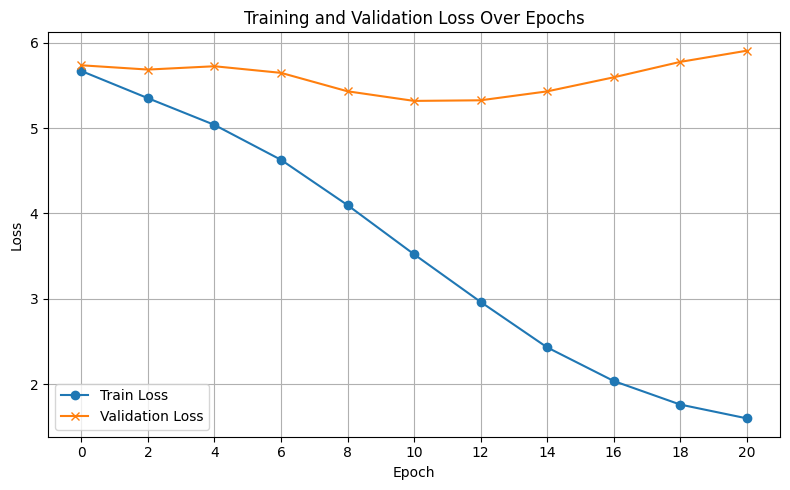

In [ ]:
epochs = list(range(1, len(train_loss) + 1))
plt.figure(figsize=(8, 5))
plt.plot(epochs, train_loss, label='Train Loss', marker='o')
plt.plot(epochs,val_loss, label='Validation Loss', marker='x')

labels = range(0, len(train_loss)*2, 2)
plt.xlabel('Epoch')
plt.xticks(epochs, labels)
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()